## Creating Custom Datasets and Finetuning Pre-trained Networks
In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import glob
from torch.autograd import Variable
from PIL import Image
import torchvision
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [2]:
batch_size = 5
num_epochs = 5
learning_rate = 0.0001

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.train = train
        self.transform = transform
        self.dataset = []
        tdir = "train"
        if train==False:
            tdir = "test"
        for filepath in glob.glob(root_dir+"/"+tdir+"/*/*.png"):
            label = ord(filepath.split("/")[-2]) - ord('A')
            with Image.open(filepath) as img:
                image = img.convert('RGB')
            self.dataset.append((image,label))
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.dataset)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        img, lab = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, lab
        

In [4]:
use_gpu = True

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

Size of train dataset: 16854
Size of test dataset: 1870
Train images
Test images


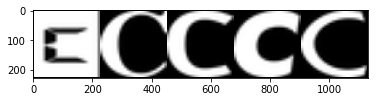

In [5]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='notMNIST_small', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='notMNIST_small', train=False, transform=composed_transform) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [6]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

# Code to change the last layers so that they only have 10 classes as output
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 10),
)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Add code for using CUDA here if it is available
if(torch.cuda.is_available()):
    vgg16.cuda()
    resnet18.cuda()

Define loss functions and optimizers

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [8]:
def train_vgg16():
    # Write loops so as to train the model for N epochs, use num_epochs hyper parameter
    # Train/finetune the VGG-16 network
    # Store the losses for every epoch and generate a graph using matplotlib
    llist = []
    count = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
#             print ("loading images and labels")
            images = Variable(images)
            labels = Variable(labels)
#             print ("cuda ops")
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
#             print ("optimizer")
            # Forward + Backward + Optimize
            optimizer_vgg16.zero_grad()  # zero the gradient buffer
#             print ("pass")
            outputs = vgg16(images)
#             print ("loss")
            loss = criterion(outputs, labels)
#             print ("backprop")
            loss.backward()
#             print ("optimizer update")
            optimizer_vgg16.step()
            count = count+1
            llist.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot(np.array(range(count)),np.array(llist))
    plt.show()
    
def train_resnet18():
    # Same as above except now using the Resnet-18 network
    llist = []
    count = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer_resnet18.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet18.step()
            count = count+1
            llist.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot(np.array(range(count)),np.array(llist))
    plt.show()

Now let us start the training/finetuning

In [ ]:
%time train_vgg16()
%time train_resnet18()

Epoch [1/5], Step [5/3370], Loss: 1.9345
Epoch [1/5], Step [10/3370], Loss: 2.7151
Epoch [1/5], Step [15/3370], Loss: 2.3381
Epoch [1/5], Step [20/3370], Loss: 2.3469
Epoch [1/5], Step [25/3370], Loss: 1.6572
Epoch [1/5], Step [30/3370], Loss: 2.6695
Epoch [1/5], Step [35/3370], Loss: 1.6433
Epoch [1/5], Step [40/3370], Loss: 1.3165
Epoch [1/5], Step [45/3370], Loss: 1.4440
Epoch [1/5], Step [50/3370], Loss: 0.2796
Epoch [1/5], Step [55/3370], Loss: 0.7808
Epoch [1/5], Step [60/3370], Loss: 0.4132
Epoch [1/5], Step [65/3370], Loss: 0.5069
Epoch [1/5], Step [70/3370], Loss: 0.5331
Epoch [1/5], Step [75/3370], Loss: 0.2583
Epoch [1/5], Step [80/3370], Loss: 0.7435
Epoch [1/5], Step [85/3370], Loss: 0.2786
Epoch [1/5], Step [90/3370], Loss: 0.5787
Epoch [1/5], Step [95/3370], Loss: 0.3969
Epoch [1/5], Step [100/3370], Loss: 0.2179
Epoch [1/5], Step [105/3370], Loss: 1.2394
Epoch [1/5], Step [110/3370], Loss: 0.0099
Epoch [1/5], Step [115/3370], Loss: 1.3363
Epoch [1/5], Step [120/3370], L

#### Testing
Once finetuning is done we need to test it on the test set.

In [ ]:
def test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Test the models

In [ ]:
%time test(vgg16)
%time test(resnet18)

You can add more code to save the models if you want but otherwise this notebook is complete